# Missing Values
There are three approaches to dealing with missing values. We'll go through them then we'll compare the effectiveness of these approaches on a real-world dataset.



## Introduction
There are many ways data can end up with missing values. For example,

A 2 bedroom house won't include a value for the size of a third bedroom.
A survey respondent may choose not to share his income.
Most machine learning libraries (including scikit-learn) give an error if you try to build a model using data with missing values. So you'll need to choose one of the strategies below.

## Three Approaches


### 1) A Simple Option: Drop Columns with Missing Values
The simplest option is to drop columns with missing values.

tut2_approach1

Unless most values in the dropped columns are missing, the model loses access to a lot of (potentially useful!) information with this approach. As an extreme example, consider a dataset with 10,000 rows, where one important column is missing a single entry. This approach would drop the column entirely!



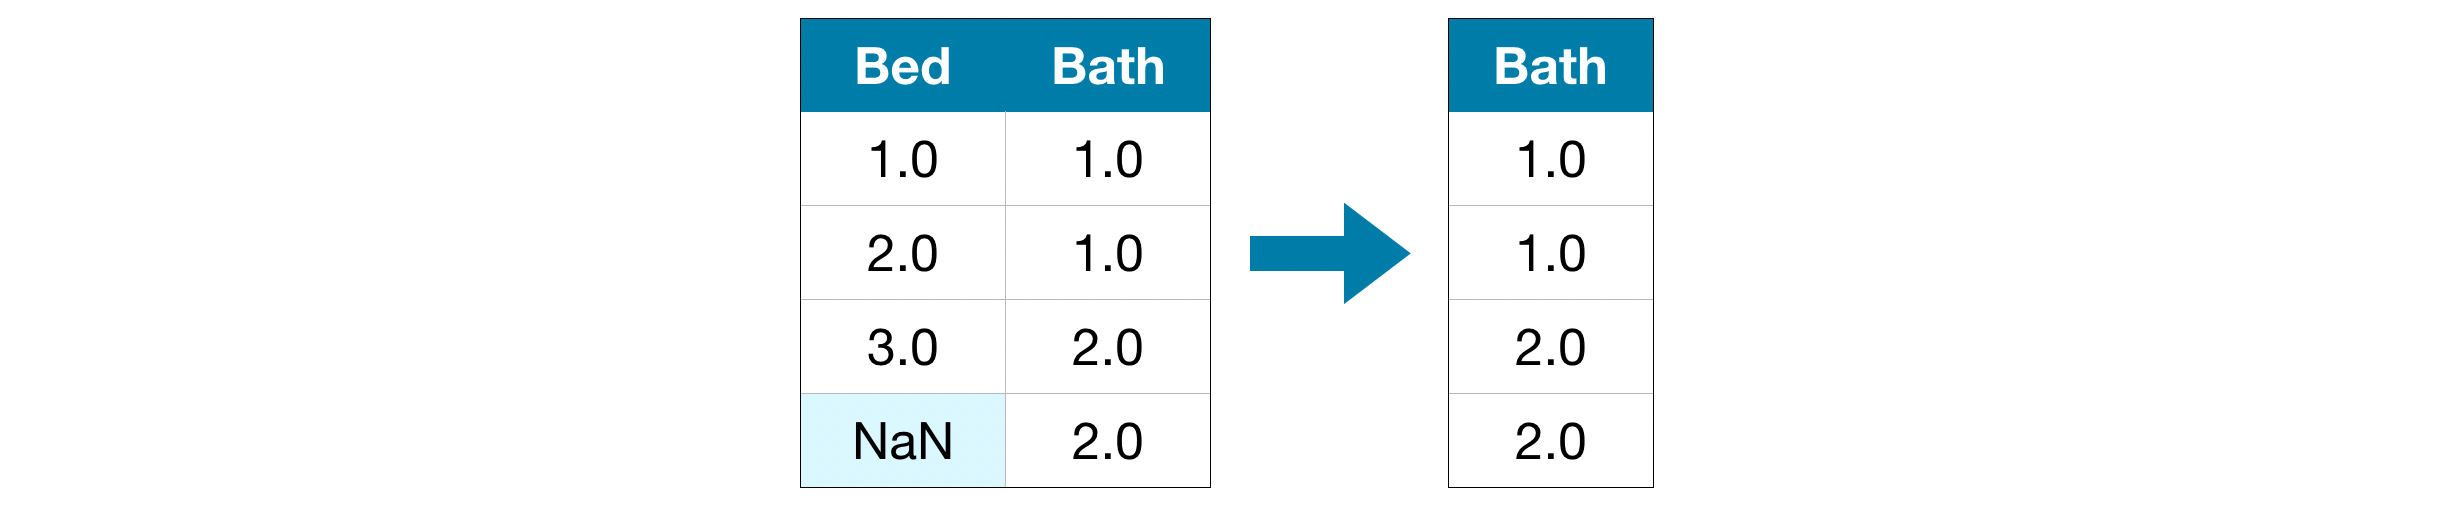

### 2) A Better Option: Imputation
Imputation fills in the missing values with some number. For instance, we can fill in the mean value along each column.

tut2_approach2

The imputed value won't be exactly right in most cases, but it usually leads to more accurate models than you would get from dropping the column entirely.



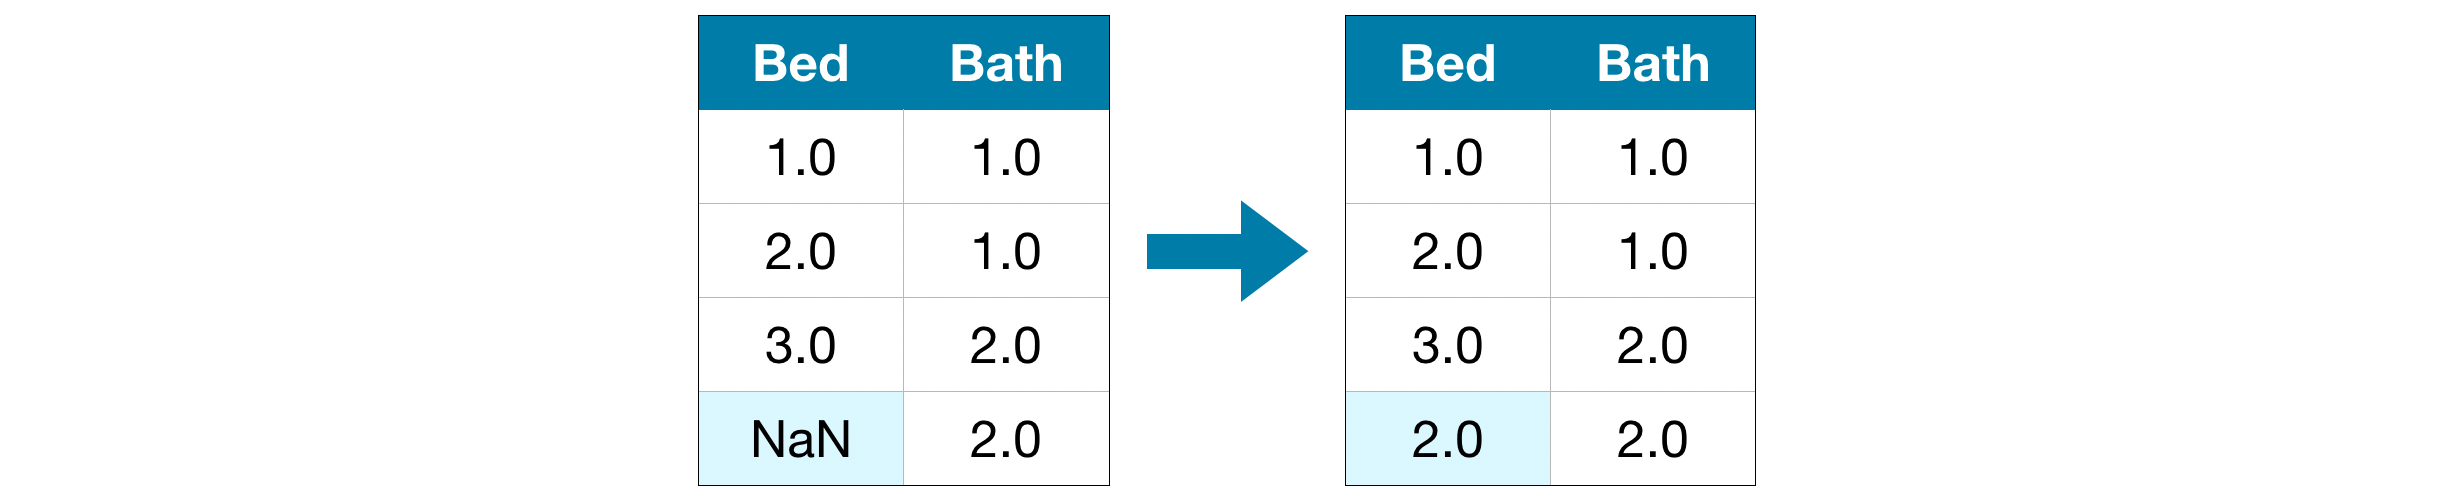

### 3) An Extension To Imputation
Imputation is the standard approach, and it usually works well. However, imputed values may be systematically above or below their actual values (which weren't collected in the dataset). Or rows with missing values may be unique in some other way. In that case, your model would make better predictions by considering which values were originally missing.

tut3_approach3

In this approach, we impute the missing values, as before. And, additionally, for each column with missing entries in the original dataset, we add a new column that shows the location of the imputed entries.

In some cases, this will meaningfully improve results. In other cases, it doesn't help at all.



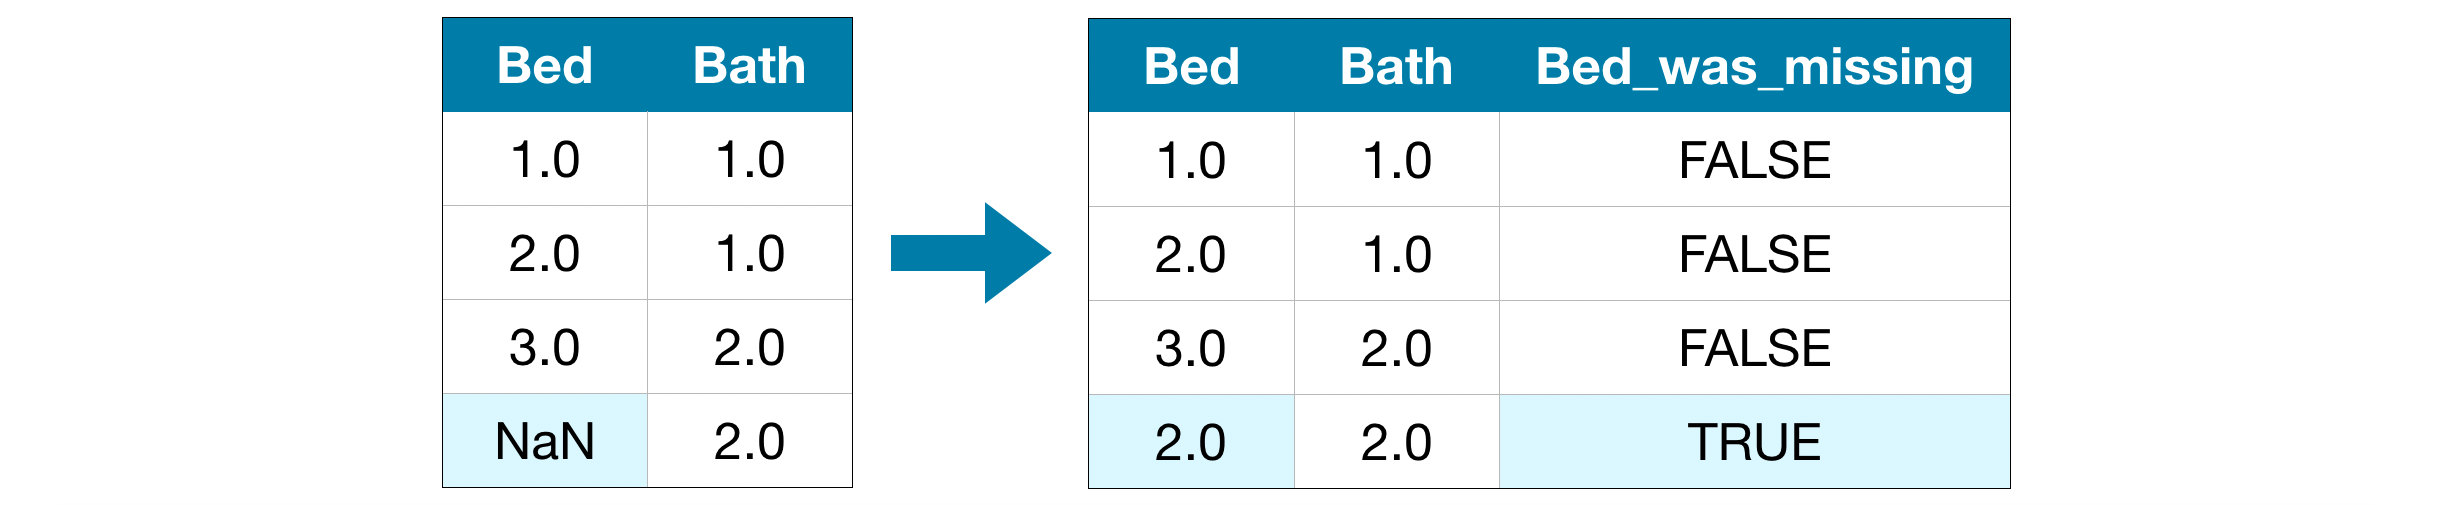

## Example
In the example, we will work with the Melbourne Housing dataset. Our model will use information such as the number of rooms and land size to predict home price.

We won't focus on the data loading step. Instead, you can imagine you are at a point where you already have the training and validation data in X_train, X_valid, y_train, and y_valid.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the data
data = pd.read_csv('/content/melb_data.csv')

# Select target
y = data.Price

# To keep things simple, we'll use only numerical predictors
melb_predictors = data.drop(['Price'], axis=1)
X = melb_predictors.select_dtypes(exclude=['object'])

# Divide data into training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

### Define Function to Measure Quality of Each Approach
We define a function score_dataset() to compare different approaches to dealing with missing values. This function reports the mean absolute error (MAE) from a random forest model.

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=10, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

### Score from Approach 1 (Drop Columns with Missing Values)
Since we are working with both training and validation sets, we are careful to drop the same columns in both DataFrames.

In [4]:
# Get names of columns with missing values
cols_with_missing = [col for col in X_train.columns
                     if X_train[col].isnull().any()]

# Drop columns in training and validation data
reduced_X_train = X_train.drop(cols_with_missing, axis=1)
reduced_X_valid = X_valid.drop(cols_with_missing, axis=1)

print("MAE from Approach 1 (Drop columns with missing values):")
print(score_dataset(reduced_X_train, reduced_X_valid, y_train, y_valid))

MAE from Approach 1 (Drop columns with missing values):
183550.22137772635


### Score from Approach 2 (Imputation)
Next, we use SimpleImputer to replace missing values with the mean value along each column.

Although it's simple, filling in the mean value generally performs quite well (but this varies by dataset). While statisticians have experimented with more complex ways to determine imputed values (such as regression imputation, for instance), the complex strategies typically give no additional benefit once you plug the results into sophisticated machine learning models.

In [5]:
from sklearn.impute import SimpleImputer

# Imputation
my_imputer = SimpleImputer()
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))
imputed_X_valid = pd.DataFrame(my_imputer.transform(X_valid))

# Imputation removed column names; put them back
imputed_X_train.columns = X_train.columns
imputed_X_valid.columns = X_valid.columns

print("MAE from Approach 2 (Imputation):")
print(score_dataset(imputed_X_train, imputed_X_valid, y_train, y_valid))

MAE from Approach 2 (Imputation):
178166.46269899711


We see that Approach 2 has lower MAE than Approach 1, so Approach 2 performed better on this dataset.



### Score from Approach 3 (An Extension to Imputation)
Next, we impute the missing values, while also keeping track of which values were imputed.

In [6]:
# Make copy to avoid changing original data (when imputing)
X_train_plus = X_train.copy()
X_valid_plus = X_valid.copy()

# Make new columns indicating what will be imputed
for col in cols_with_missing:
    X_train_plus[col + '_was_missing'] = X_train_plus[col].isnull()
    X_valid_plus[col + '_was_missing'] = X_valid_plus[col].isnull()

# Imputation
my_imputer = SimpleImputer()
imputed_X_train_plus = pd.DataFrame(my_imputer.fit_transform(X_train_plus))
imputed_X_valid_plus = pd.DataFrame(my_imputer.transform(X_valid_plus))

# Imputation removed column names; put them back
imputed_X_train_plus.columns = X_train_plus.columns
imputed_X_valid_plus.columns = X_valid_plus.columns

print("MAE from Approach 3 (An Extension to Imputation):")
print(score_dataset(imputed_X_train_plus, imputed_X_valid_plus, y_train, y_valid))

MAE from Approach 3 (An Extension to Imputation):
178927.503183954


As we can see, Approach 3 performed slightly worse than Approach 2.

### So, why did imputation perform better than dropping the columns?
The training data has 10864 rows and 12 columns, where three columns contain missing data. For each column, less than half of the entries are missing. Thus, dropping the columns removes a lot of useful information, and so it makes sense that imputation would perform better.

In [7]:
# Shape of training data (num_rows, num_columns)
print(X_train.shape)

# Number of missing values in each column of training data
missing_val_count_by_column = (X_train.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

(10864, 12)
Car               49
BuildingArea    5156
YearBuilt       4307
dtype: int64


## Conclusion
As is common, imputing missing values (in Approach 2 and Approach 3) yielded better results, relative to when we simply dropped columns with missing values (in Approach 1).